In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pathlib
# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import time
import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.1)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

In [28]:
NUM_CLASSES = 8

category_index = {1: {'id': 1, 'name': 'bone'},
                  2: {'id': 2, 'name': 'abdomen'},
                  3: {'id': 3, 'name': 'mediastinum'},
                  4: {'id': 4, 'name': 'liver'},
                  5: {'id': 5, 'name': 'lung'},
                  6: {'id': 6, 'name': 'kidney'},
                  7: {'id': 7, 'name': 'soft_tissue'},
                  8: {'id': 8, 'name': 'pelvis'}}

def _parse_function(example_proto):
    feature_description = {
        'image/height': tf.io.FixedLenFeature((), tf.int64, default_value=1),
        'image/width': tf.io.FixedLenFeature((), tf.int64, default_value=1),
        'image/win_min': tf.io.FixedLenFeature((), tf.float32, default_value=-1024.),
        'image/win_max': tf.io.FixedLenFeature((), tf.float32, default_value=3071.), 
        'image/filename': tf.io.FixedLenFeature((), tf.string, default_value=''),
        'image/source_id': tf.io.FixedLenFeature((), tf.string, default_value=''),    
        'image/encoded': tf.io.FixedLenFeature((), tf.string, default_value=''),
        'image/format': tf.io.FixedLenFeature((), tf.string, default_value='jpeg'),
        # Object boxes and classes.
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/text': tf.io.VarLenFeature(tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }  
    return tf.io.parse_single_example(example_proto, feature_description)

def GetImageLabelBoxTensors(image_features, batch_size):
    train_image_tensors = []
    gt_box_tensors = []
    gt_classes_one_hot_tensors = [] 
    num_classes = NUM_CLASSES
    label_id_offset = 1
    for i in range(batch_size):
#       print('i = {}'.format(i))
        image = tf.io.decode_png(image_features['image/encoded'][i], channels=3)
        image = tf.cast(image, tf.float32)
        image = tf.expand_dims(image, axis=0)
        xmins = tf.sparse.to_dense(image_features['image/object/bbox/xmin'])[i:i+1]
        xmaxs = tf.sparse.to_dense(image_features['image/object/bbox/xmax'])[i:i+1]
        ymins = tf.sparse.to_dense(image_features['image/object/bbox/ymin'])[i:i+1]
        ymaxs = tf.sparse.to_dense(image_features['image/object/bbox/ymax'])[i:i+1]
        bbox = tf.concat([ymins, xmins, ymaxs, xmaxs], 0)        
        bbox = tf.transpose(bbox)
        labels_np = tf.sparse.to_dense(image_features['image/object/class/label'])[i].numpy()
        zero_args = np.argwhere(labels_np == 0)
        if zero_args.size > 0:
            num_bbox = zero_args[0][0]
            labels_np = labels_np[:num_bbox]
            bbox = bbox[:num_bbox] 
#            print('labels = {}'.format(labels_np))
        zero_indexed_groundtruth_classes = tf.convert_to_tensor(labels_np - label_id_offset)
        gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))
        train_image_tensors.append(image)
        gt_box_tensors.append(bbox)    
    return train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):

    """Run detection on an input image.
    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
    Note that height and width can be anything since the image will be
    immediately resized according to the needs of the model within this
    function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
    and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)

def get_latest_ckpt(dir):
    search = dir + '/*.index'
    ckpts = glob.glob(search)
    lastest_ckpt = ''
    max_idx = -1
    for item in ckpts:
        item1 = item[:item.index('.')]
        idx = int(item1[item1.index('-')+1:])
        #print(item1, idx)
        if (idx > max_idx):
            max_idx = idx
            lastest_ckpt = item1
    return lastest_ckpt

# bbox[ymin, xmin, ymax, xmax]
def get_iou(bbox1, bbox2):
    if (bbox1[1] > bbox2[3] or bbox2[1] > bbox1[3] or bbox1[0] > bbox2[2] or bbox2[0] > bbox1[2]):
        return 0.0
    overlap = ((min(bbox1[3], bbox2[3]) - max(bbox1[1], bbox2[1])) * (min(bbox1[2], bbox2[2]) - max(bbox1[0], bbox2[0])))
    union = ((bbox1[3] - bbox1[1]) * (bbox1[2] - bbox1[0]) + (bbox2[3] - bbox2[1]) * (bbox2[2] - bbox2[0]) - overlap)
#    print('overlap = {}, union = {}, ret = {}'.format(overlap, union, overlap/union))
    return overlap / union

def merge_markers(in_markers, in_scores, in_labels, low_score=0.1, iou_thrd=0.4):
    delete_id = []
    for i in range(len(in_scores)):
        if (in_scores[i] <= low_score):
            delete_id.append(i)
    in_markers = np.delete(in_markers, delete_id, 0)
    in_scores = np.delete(in_scores, delete_id, 0)
    in_labels = np.delete(in_labels, delete_id, 0)
    delete_id = []
    for i in range(len(in_scores)):
        for j in range(i+1, len(in_scores)):
            iou = get_iou(in_markers[i], in_markers[j])
            if (iou >= iou_thrd):
                if (in_scores[i] > in_scores[j]):
                    delete_id.append(j)
                else:
                    delete_id.append(i)    
    out_markers = np.delete(in_markers, delete_id, 0)
    out_scores = np.delete(in_scores, delete_id, 0)
    out_labels = np.delete(in_labels, delete_id, 0)       
    return out_markers, out_scores, out_labels

In [6]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2022-03-21 04:08:38--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.197.128, 2607:f8b0:400e:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.197.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   179MB/s    in 1.3s    

2022-03-21 04:08:40 (179 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [9]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = NUM_CLASSES
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = get_latest_ckpt('/content/drive/MyDrive/my_model')

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(model_config=model_config, is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
if (len(checkpoint_path) > 0):
    ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


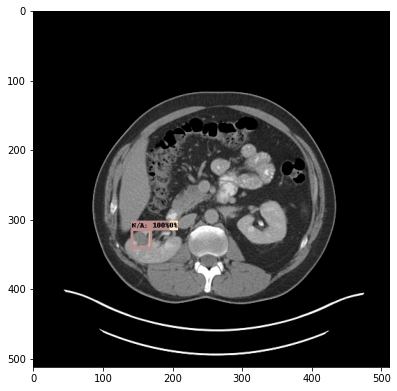

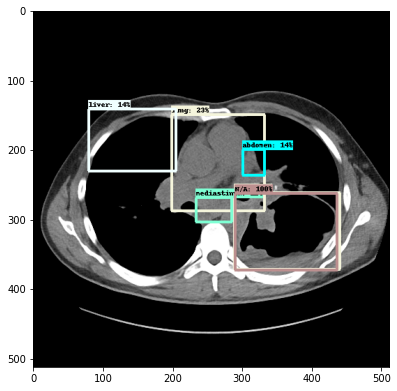

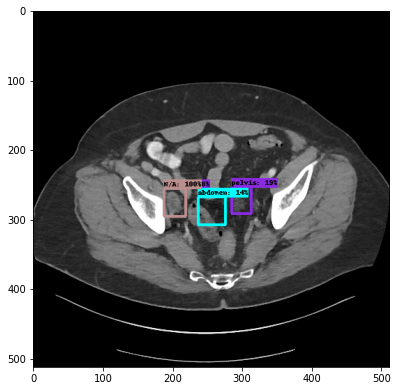

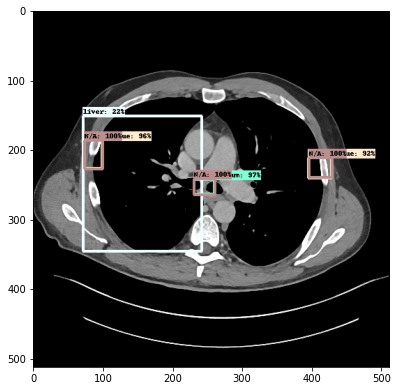

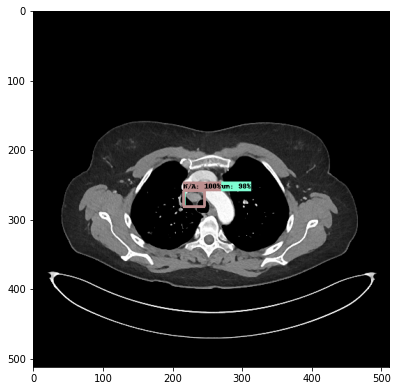

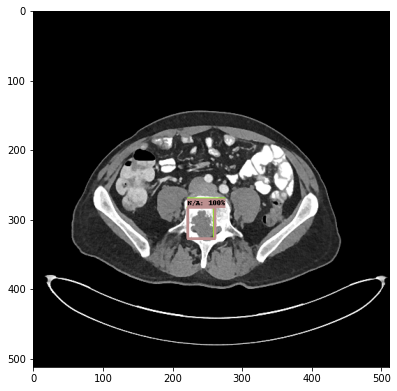

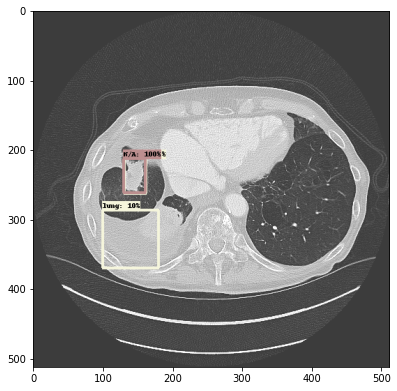

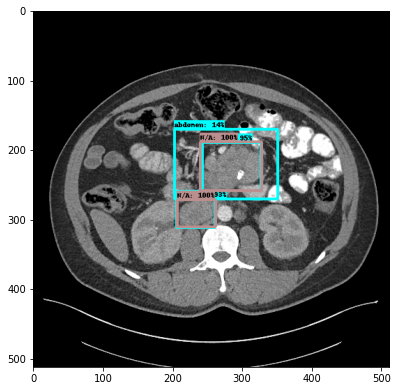

In [35]:
batch_size = 1
eval_tfr_path = ['/content/drive/MyDrive/data1/val_deeplesion.record-00028-of-00030']
valset = tf.data.TFRecordDataset(eval_tfr_path)
valset = valset.map(_parse_function)
valset = valset.batch(batch_size) 

tf.keras.backend.clear_session()
testdata = iter(valset)
label_id_offset = 1

for i in range(8):
    image_features = next(testdata)
    image_tensors, gt_boxes_list, gt_classes_list = GetImageLabelBoxTensors(image_features, batch_size)
    image_tensors, gt_boxes_list, gt_classes_list = GetImageLabelBoxTensors(image_features, 1)
    detections = detect(image_tensors[0])
    det_boxes = detections['detection_boxes'][0].numpy()
    det_labels = detections['detection_classes'][0].numpy().astype(np.uint32) + label_id_offset
    det_scores = detections['detection_scores'][0].numpy()
    out_boxes, out_scores, out_labels = merge_markers(det_boxes, det_scores, det_labels)
    gt_boxes = gt_boxes_list[0].numpy()
    image_np = (image_tensors[0].numpy())[0]
    image_np = image_np.astype(np.uint8)
    gt_labels = np.ones_like(gt_classes_list[0].numpy().reshape((-1,))) * 99
    gt_scores = np.ones_like(gt_labels)
    gt_labels = gt_labels.astype(det_labels.dtype)
    out_boxes = np.concatenate((out_boxes, gt_boxes), axis=0)
    out_labels = np.concatenate((out_labels, gt_labels), axis=0)
    out_scores = np.concatenate((out_scores, gt_scores), axis=0)
    plt.figure(figsize=(60, 30))
    plt.subplot(1, 8, i+1)
    plot_detections(image_np, out_boxes, out_labels, out_scores, category_index)
    #plot_detections(image_np, out_boxes, out_labels, out_scores, category_index, figsize=(15, 20), image_name="/content/drive/MyDrive/demo_frame_" + ('%02d' % i) + ".jpg")